<a href="https://colab.research.google.com/github/grefenail/grefenail/blob/main/cnn_resnet50_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [2]:
pip install watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.8 MB/s eta 0:00:00


In [3]:
pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -v -p torch

ModuleNotFoundError: No module named 'watermark'

# Model Zoo -- CNN Gender Classifier (ResNet-50 Architecture, CelebA) with Data Parallelism

### Network Architecture

The network in this notebook is an implementation of the ResNet-50 [1] architecture on the CelebA face dataset [2] to train a gender classifier.  


References
    
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). Gender and smile classification using deep convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 34-38).

The ResNet-50 architecture is similar to the ResNet-34 architecture shown below (from [1]):


![](../images/resnets/resnet34/resnet34-arch.png)

However, in ResNet-50, the skip connection uses a bottleneck (from [1]):


![](../images/resnets/resnet50/resnet50-arch-1.png)


The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.

![](../images/resnets/resnet-ex-1-1.png)


The ResNet-34 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:

![](../images/resnets/resnet-ex-1-2.png)

The ResNet-50 uses a bottleneck as shown below:

![](../images/resnets/resnet-ex-1-3.png)

For a more detailed explanation see the other notebook, [resnet-ex-1.ipynb](resnet-ex-1.ipynb).

## Imports

In [3]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [4]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

### MNIST Dataset

In [8]:
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset  # Hugging Face streaming dataset

In [6]:
from huggingface_hub import login
login()

In [7]:
import torch
import torchvision.transforms as transforms
from datasets import load_dataset
import io
from PIL import Image
import random

# **1️⃣ Define Mini-ImageNet Transformations**
mini_imagenet_transforms = transforms.Compose([
    transforms.Resize((84, 84)),  # ✅ Resize to 84x84 for Mini-ImageNet
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure RGB format
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **2️⃣ Load ImageNet-1K (Streaming)**
dataset = load_dataset("imagenet-1k", streaming=True)
train_dataset, test_dataset = dataset["train"], dataset["validation"]

# **3️⃣ Select 100 Random Classes**
all_labels = list(set([example["label"] for example in train_dataset.take(10000)]))  # Sample first 10k images
random.seed(42)
selected_labels = random.sample(all_labels, 100)  # ✅ Pick 100 classes

# **4️⃣ Convert image paths or bytes to tensors & ensure labels are in [0, 99]**
def transform_data(batch):
    if isinstance(batch["image"], str):
        batch["image"] = Image.open(batch["image"]).convert("RGB")
    elif isinstance(batch["image"], bytes):
        batch["image"] = Image.open(io.BytesIO(batch["image"])).convert("RGB")

    batch["image"] = mini_imagenet_transforms(batch["image"])

    # ✅ Map labels from 1000-class range to 100-class range
    batch["label"] = selected_labels.index(batch["label"])  # Convert label to range [0, 99]
    batch["label"] = torch.tensor(batch["label"], dtype=torch.long)

    return batch

# **5️⃣ Apply Transformations**
train_dataset = train_dataset.filter(lambda x: x["label"] in selected_labels)  # ✅ Keep only selected 100 classes
test_dataset = test_dataset.filter(lambda x: x["label"] in selected_labels)

train_dataset = train_dataset.map(transform_data)
test_dataset = test_dataset.map(transform_data)

# **6️⃣ Custom collate function for batching**
def collate_fn(batch):
    images = torch.stack([b["image"] for b in batch])
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    return images, labels

# **7️⃣ Create DataLoaders**
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=4)

# **8️⃣ Check dataset (debugging)**
for batch in train_loader:
    images, labels = batch
    print("Image batch shape:", images.shape)  # Expected: [64, 3, 84, 84]
    print("Label batch range:", labels.min().item(), "-", labels.max().item())  # Expected: 0-99
    break


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Image batch shape: torch.Size([64, 3, 224, 224])
Label batch shape: torch.Size([64])
Label batch type: torch.int64


In [8]:
device = torch.device("cpu")
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
Epoch: 2 | Batch index: 0 | Batch size: 64


The following code cell that implements the ResNet-34 architecture is a derivative of the code provided at https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# 3x3 Convolution Layer
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# Basic Block for ResNet-34
class BasicBlock(nn.Module):
    expansion = 1  # ResNet-34 does not expand channels like Bottleneck

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

# ResNet Model
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        super(ResNet, self).__init__()
        self.inplanes = 64
        in_dim = 1 if grayscale else 3  # Accept grayscale or RGB

        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # More flexible pooling
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)  # No softmax here
        return logits  # Removed `probas` to match PyTorch best practices

# ResNet-34 Constructor (Fixed)
def resnet34(num_classes=1000, grayscale=False):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, layers=[3, 4, 6, 3], num_classes=num_classes, grayscale=grayscale)
    return model


In [10]:
torch.manual_seed(RANDOM_SEED)

model = resnet34(NUM_CLASSES)
model.to("cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [19]:
def transform_data(batch):
    if isinstance(batch["image"], str):
        batch["image"] = Image.open(batch["image"]).convert("RGB")
    elif isinstance(batch["image"], bytes):
        batch["image"] = Image.open(io.BytesIO(batch["image"])).convert("RGB")

    batch["image"] = imagenet_transforms(batch["image"])

    # ✅ Ensure label is a valid integer
    batch["label"] = int(batch["label"])

    # ✅ Ensure label is within the range [0, 999]
    if batch["label"] < 0 or batch["label"] >= 1000:
        print(f"❌ Warning: Invalid label {batch['label']} detected. Fixing it.")
        batch["label"] = 999  # Assign the highest valid label to prevent crashes

    batch["label"] = torch.tensor(batch["label"], dtype=torch.long)  # Convert to tensor
    return batch

In [ ]:
logits = model(features)
print(f"Logits shape: {logits.shape}")  # Should be (batch_size, 1000)

In [20]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to("cpu")
        targets = targets.to("cpu")

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()
for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to("cpu")
        targets = targets.to("cpu")

        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))



    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS,
              compute_accuracy(model, train_loader, device=DEVICE)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

IndexError: Target 252 is out of bounds.

# New Section

## Evaluation

In [1]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

NameError: name 'torch' is not defined

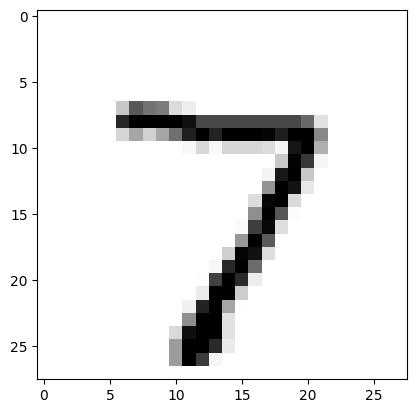

In [ ]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break


nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [ ]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%


In [ ]:
%watermark -iv

matplotlib : 3.10.0
PIL        : 11.1.0
torchvision: 0.20.1+cu124
numpy      : 1.26.4
pandas     : 2.2.2
torch      : 2.5.1+cu124

